<a href="https://colab.research.google.com/github/flecue/xai-aaai2022/blob/main/XAI_Concept_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👋 Welcome to the **Concept Methods** tutorial


In this tutorial, we will take a pre-trained model, extract the _Concept Activation Vector_ for the 'striped' concept and test the influence of this concept on the zebra class.

💡 In order to better understand this notebook, it is recommended to be at ease with the super cool paper at the origin of this idea:
_Interpretability Beyond Feature Attribution: Quantitative Testing with Concept Activation Vectors (TCAV)_ Kim & al, 2018,
https://arxiv.org/pdf/1711.11279.pdf

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1K14-wQj7LHBUdqggMjcbRzwwUKGu426Q"/>
</p>



- 📘 <a href="https://deel-ai.github.io/xplique"> Documentation </a>
- <img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> <a href="https://github.com/deel-ai/xplique"> Github </a>
- 🦊 <a href="https://github.com/deel-ai/xplique/blob/master/TUTORIALS.md"> More Xplique tutorials </a>



Step 1 : Installing **Xplique** and utils

In [1]:
!pip install -q xplique

import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

import xplique

     |████████████████████████████████| 101 kB 3.9 MB/s 


# Load images that contain the concepts we want to test

We will use Broden dataset, this dataset contains images related to concept like 'striped', 'veined'...

In [2]:
!curl -O http://netdissect.csail.mit.edu/data/broden1_224.zip
!unzip -qq broden1_224.zip
!rm broden1_224.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  894M  100  894M    0     0  60.4M      0  0:00:14  0:00:14 --:--:-- 62.4M


Util that will help us to load images

In [3]:
def central_crop_and_resize(img, input_size):
  """
  given a numpy array, extracts the largest possible square and resizes it to the requested size
  """
  h, w, _ = img.shape

  min_side = min(h, w)
  max_side_center = max(h, w) // 2.0
  
  min_cut = int(max_side_center-min_side//2)
  max_cut = int(max_side_center+min_side//2)
  
  img = img[:, min_cut:max_cut] if w > h else img[min_cut:max_cut]
  img = tf.image.resize(img, (input_size, input_size)).numpy()

  return img 

Let's load images associated to the concept we want to test

The Texture available are : 
- banded
- blotchy
- braided
- bubbly
- bumpy
- chequered
- cobwebbed
- cracked
- crosshatched
- crystalline
- dotted
- fibrous
- flecked
- freckled
- frilly
- gauzy
- grid
- grooved
- honeycombed
- interlaced
- knitted
- lacelike
- lined
- marbled
- matted
- meshed
- paisley
- perforated
- pitted
- pleated
- polka-dotted
- porous
- potholed
- scaly
- smeared
- spiralled
- sprinkled
- stained
- stratified
- striped
- studded
- swirly
- veined
- waffled
- woven
- wrinkled
- zigzagged


Texture: knitted  - shape: (53, 299, 299, 3)


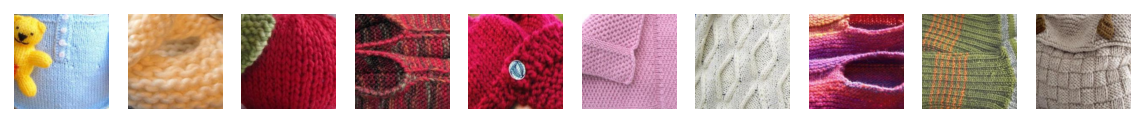



Texture: striped  - shape: (82, 299, 299, 3)


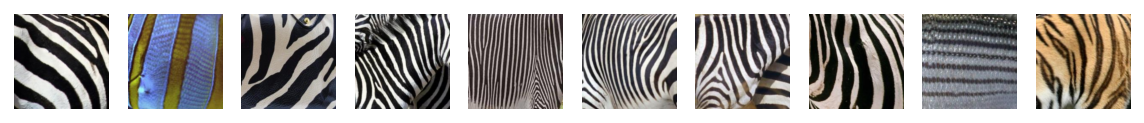



Texture: bubbly  - shape: (110, 299, 299, 3)


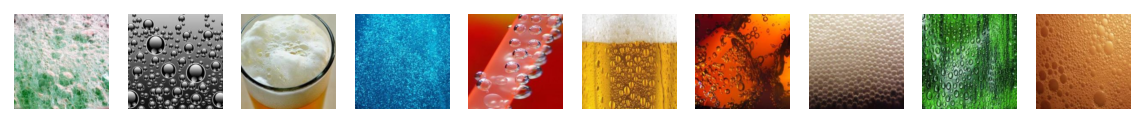

In [4]:
texture_folder    = 'broden1_224/images/dtd/'
random_img_folder = 'broden1_224/images/pascal/'
input_size = 299

textures_files = os.listdir(texture_folder)
textures_availables = np.unique([t.split('_')[0] for t in textures_files])
print('The Texture available are : \n-', '\n- '.join(textures_availables))

def load_texture(texture):
  files = [texture_folder + t for t in textures_files if texture in t]
  imgs  = [cv2.imread(img)[...,::-1] for img in files]
  imgs  = [central_crop_and_resize(img, input_size) for img in imgs]
  imgs  = [np.array(img, np.float32) for img in imgs if img.max() > 250]
  imgs  = np.array(imgs)
  return imgs

to_load = ['knitted', 'striped', 'bubbly']
textures = {texture: load_texture(texture) for texture in to_load}

plt.rcParams["figure.figsize"] = [10, 5]
for texture_name, images in textures.items():
  print(f"\n\nTexture: {texture_name}  - shape: {images.shape}")
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i] / 255.0)
    plt.axis('off')
  plt.show()

# 📷 Load natural image data

These images will be our negative anchors, the goal will be to compare the embedding of the model between the images containing the concept and the natural images in order to deduce the concept vector.

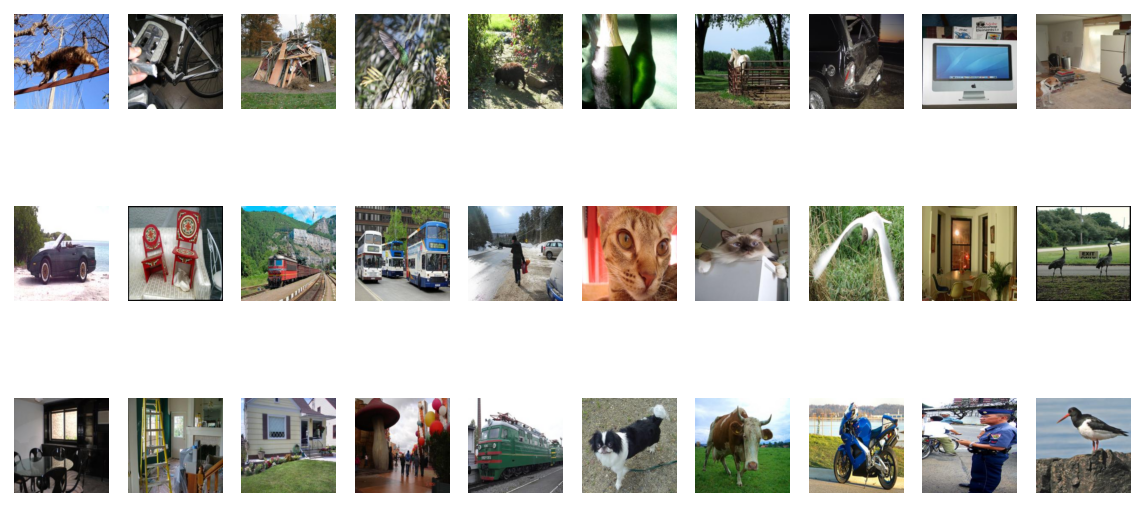

In [5]:
random_imgs = os.listdir(random_img_folder)
random_imgs_filter = lambda f : all([rm not in f for rm in ['object', 'color', 'part']]) # only take 'natural' image

def load_random_images(nb_samples):
  files = [img for img in random_imgs]
  files = list(filter(random_imgs_filter, files))
  files = np.random.choice(files, nb_samples, replace=False)
  
  imgs = [cv2.imread(random_img_folder+img)[...,::-1] for img in files]
  imgs = [central_crop_and_resize(img, input_size) for img in imgs]
  imgs = [np.array(img, np.float32) for img in imgs if img.max() > 250]
  
  return np.array(imgs)

random_dataset = load_random_images(1000)

for i in range(30):
  plt.subplot(3, 10, i+1)
  plt.imshow(random_dataset[i] / 255.0)
  plt.axis('off')

# 🙌 Now we can extract the Concept Activation Vector (CAV) ! 

To extract this concept vector, we need positive elements (containing the concept) and negative elements (not containing the concept). 


Let's load a pre-trained model, preprocess our input for this model and extract our first CAV.




In [6]:
import tensorflow.keras.applications as app

model, preprocess = app.InceptionV3(), app.inception_v3.preprocess_input
layer_target = 'mixed5'

# remove the softmax because we are only interested in the value of the logits
model.layers[-1].activation = tf.keras.activations.linear

96124928/96112376 [==============================] - 1s 0us/step


To generate our Cav, we first need to prepare our extractor:

```python
extractor = Cav(self,
                model: tf.keras.Model,
                target_layer: Union[str, int],
                classifier: Union[str, Callable] = 'SGD',
                test_fraction: float = 0.2,
                batch_size: int = 64,
                verbose: bool = False)
```
Then we can extract multiple Cav by passing a samples containing our concept (`positive_dataset`) and random samples (`negative_dataset`): 
```python
cav = extractor(positive_dataset: tf.Tensor,
                negative_dataset: tf.Tensor)
```


In [7]:
from xplique.concepts import Cav

striped_preprocessed = preprocess(np.array(textures['striped'], copy=True))
random_preprocessed = preprocess(np.array(random_dataset, copy=True))

print(f'Strip dataset: {striped_preprocessed.shape}, Random dataset: {random_preprocessed.shape}')

# make sure you have a balanced dataset to extract cav (~same number of positive / negative) 
cav_extractor = Cav(model, layer_target, batch_size=64)
cav_striped = cav_extractor(striped_preprocessed, random_preprocessed[:len(striped_preprocessed)])

print(f'Concept Vector for striped computed ! shape: {cav_striped.shape}')

Strip dataset: (82, 299, 299, 3), Random dataset: (841, 299, 299, 3)
Concept Vector for striped computed ! shape: (17, 17, 768)


**Congrats ! We now have your first Concept Vector 🙌**

Let's compute all the other CAVs, one for each texture before testing them. 

In [8]:
cavs = {}

for texture_name, imgs in textures.items():

  imgs_preprocessed = preprocess(np.array(imgs, copy=True))
  random_preprocessed = preprocess(np.array(random_dataset, copy=True))[:len(imgs_preprocessed)]

  cav = cav_extractor(imgs_preprocessed, random_preprocessed)
  
  cavs[texture_name] = cav

  print(f'Concept Activation Vector for {texture_name} computed.')

Concept Activation Vector for knitted computed.
Concept Activation Vector for striped computed.
Concept Activation Vector for bubbly computed.


## 🕵️ Before going further, we can inspect the extracted vector  

To do this, we will use a feature visualisation method, as you may have seen on one of the fabulous [Distill articles](https://distill.pub/2017/feature-visualization/) or using the [Lucid](https://github.com/tensorflow/lucid) library. 

Here we will simply create an artificial image that maximizes this extracted vector using the `xplique.feature_visualizations` module.

Feel free to check out the dedicated tutorials for more information.


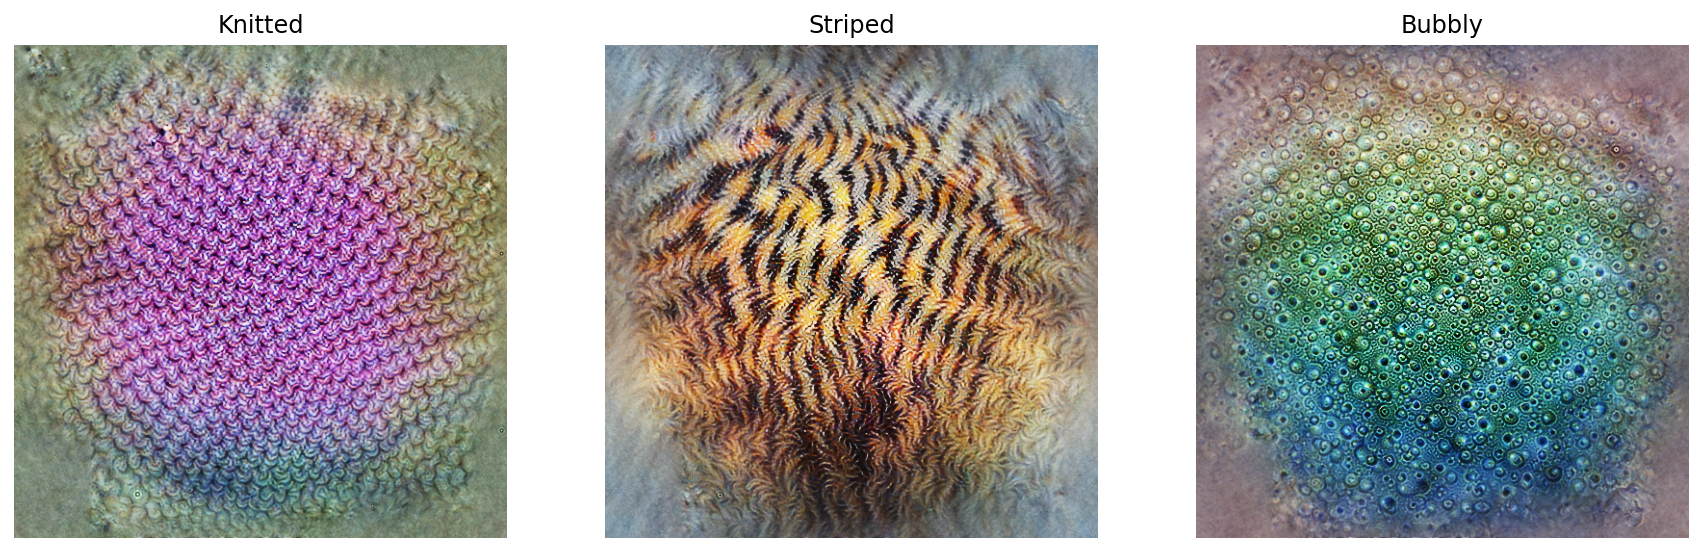

In [9]:
from xplique.features_visualizations import Objective, optimize

# first, we describe our objective, maximise in a direction: the cav
objective = Objective.direction(model, layer_target, [cav for concept_name, cav in cavs.items()])

# then we run the optimization process
images, objective_names = optimize(objective,
                                   tf.keras.optimizers.Adam(0.05),
                                   nb_steps=512)

# plot the optimized images (one for each concept)
plt.rcParams["figure.figsize"] = [15, 5]
for concept_id, (concept_name, cav) in enumerate(cavs.items()):
  img = images[0][concept_id]

  plt.subplot(1, len(cavs.keys()), concept_id+1)
  plt.imshow(img)
  plt.title(concept_name.capitalize())
  plt.axis('off')
plt.show()

# 🧪 Now it's time to test our CAVs

Here we will test the extracted concepts on some classes.

We start by extracting several CAVs by varying the random elements, then we will test the average effectiveness of these CAVs against random CAVs.

In [10]:
# extracting multiple cav for each concept
cavs = {}

random_preprocessed = preprocess(np.array(random_dataset, copy=True))[:len(imgs_preprocessed)]

nb_repeat = 30

for texture_name, imgs in textures.items():
  imgs_preprocessed = preprocess(np.array(imgs, copy=True))
  
  for repeat_id in range(nb_repeat):
    # choose different random images for each cavs repetition
    random_ids = np.random.choice(len(random_preprocessed), len(imgs_preprocessed))
    cav = cav_extractor(imgs_preprocessed, random_preprocessed[random_ids])
    
    if texture_name not in cavs:
      cavs[texture_name] = []

    cavs[texture_name].append(cav)
  
  print(f"Done for texture {texture_name}.")

# do the same things for random images
for repeat_id in range(nb_repeat):
  # choose 200 random images, 100 as positive and 100 as negative
  random_ids = np.random.choice(len(random_preprocessed), 200)
  random_1, random_2 = random_ids[:100], random_ids[100:]
  
  cav = cav_extractor(random_preprocessed[random_1], random_preprocessed[random_2])
  
  if 'random' not in cavs:
    cavs['random'] = []

  cavs['random'].append(cav)

print(f"Done for texture Random.")

Done for texture knitted.
Done for texture striped.
Done for texture bubbly.
Done for texture Random.


## 🦓 We load different classes using [Unsplash](https://unsplash.com/)

to measure whether an infinitesimal change in the CAV (directional derivative) positively or negatively affects the classes.



Class: zebra  - shape: (50, 299, 299, 3)


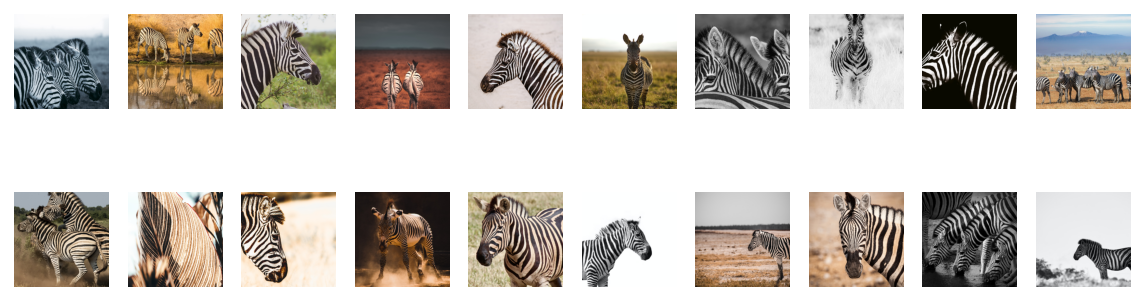



Class: tiger  - shape: (50, 299, 299, 3)


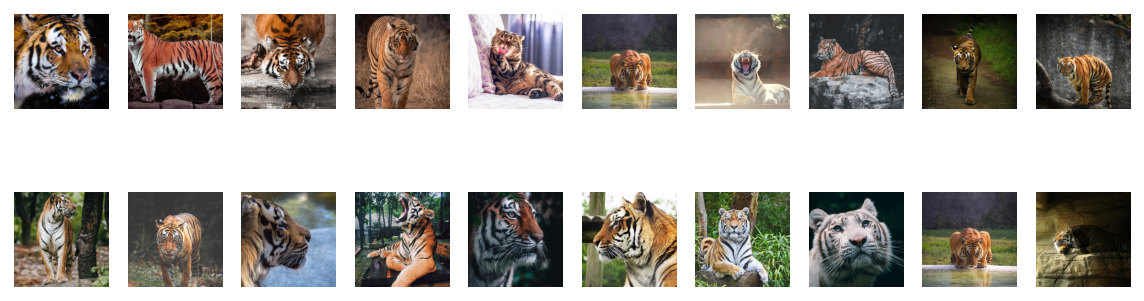



Class: squirrel  - shape: (50, 299, 299, 3)


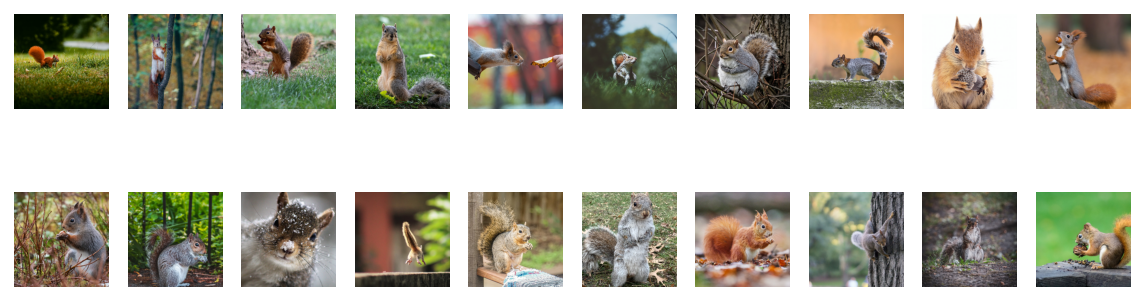

In [11]:
import time
nb_samples = 50

def load_collection(collection_name, nb_samples):
  !rm -rf $collection_name && mkdir $collection_name
  filenames = [f"{collection_name}/[{i}].jpg" for i in range(nb_samples)]
  for i in range(nb_samples):
    !curl -L --silent http://source.unsplash.com/featured?$collection_name -o "$collection_name/[$i].jpg"
    time.sleep(0.6)
  
  imgs = [cv2.imread(img)[...,::-1] for img in filenames]
  imgs = [central_crop_and_resize(img, input_size) for img in imgs]
  imgs = np.array(imgs)
  return imgs

classes_to_load = [
                   ('zebra',  340), 
                   ('tiger',  292), 
                   ('squirrel',335)
]
classes_images = {(cls, id): load_collection(cls, nb_samples) for (cls, id) in classes_to_load}

plt.rcParams["figure.figsize"] = [10, 3]
for (class_name, class_id), images in classes_images.items():
  print(f"\n\nClass: {class_name}  - shape: {images.shape}")
  for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(images[i] / 255.0)
    plt.axis('off')
  plt.show()

## And we finally test using the TCAV api

First, we generate a tester:

```python
tester = Tcav(self,
              model: tf.keras.Model,
              target_layer: Union[str, int],
              batch_size: Optional[int] = 64)
```
and then we test a cav vector against the images of a class:
```python
score = tester(self,
               inputs: tf.Tensor,
               label: int,
               cav: tf.Tensor) 
```

Of course, we will repeat this operation for each cav. We will report the mean TCAV score, and run a _Welch's_ _t_-test.

In [12]:
from xplique.concepts import Tcav

tcav_scores = {}
cav_tester = Tcav(model, layer_target)

for (class_name, class_id), imgs in classes_images.items():
  tcav_scores[class_name] = {}

  # discard all the image that have the wrong predictions
  imgs_preprocessed = preprocess(np.array(imgs, copy=True))
  predictions = np.argmax(model.predict(imgs_preprocessed, batch_size=32), -1)
  valid_imgs = imgs_preprocessed[predictions == class_id]

  # for each concept, we take all the CAVs and test them against each class
  for concept_name, _cavs in cavs.items():
    tcav_scores[class_name][concept_name] = []

    for cav in _cavs:
      score = cav_tester(valid_imgs, class_id, cav)
      tcav_scores[class_name][concept_name].append(score)

## 📈 Just plot the results and we're done !

We use the mean TCAV score and perform a _t-test_ (we could use a _Welch_'s _t-test_ if we don't assume the same variances)

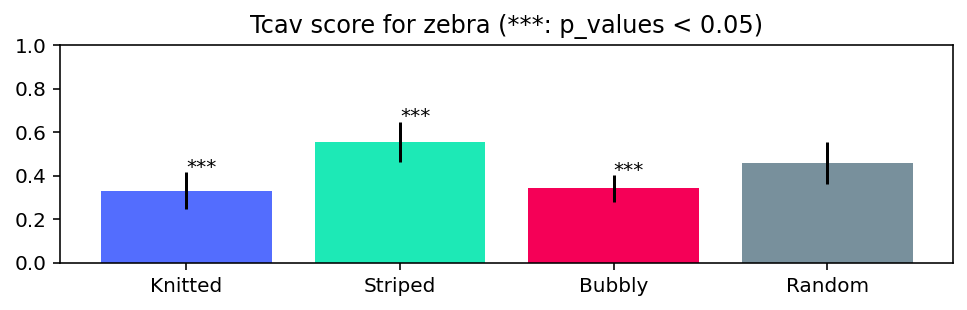

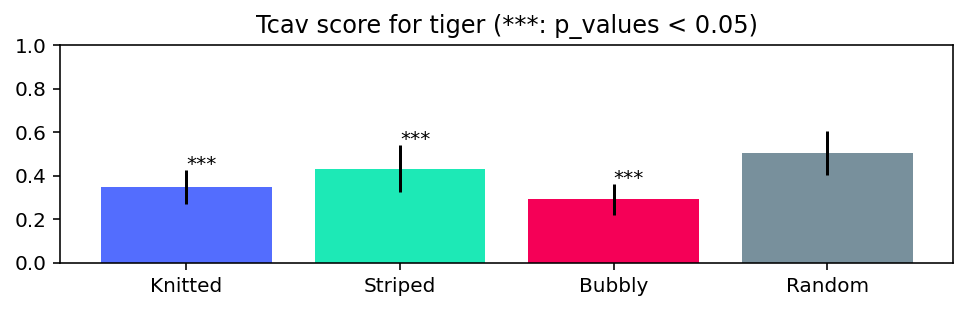

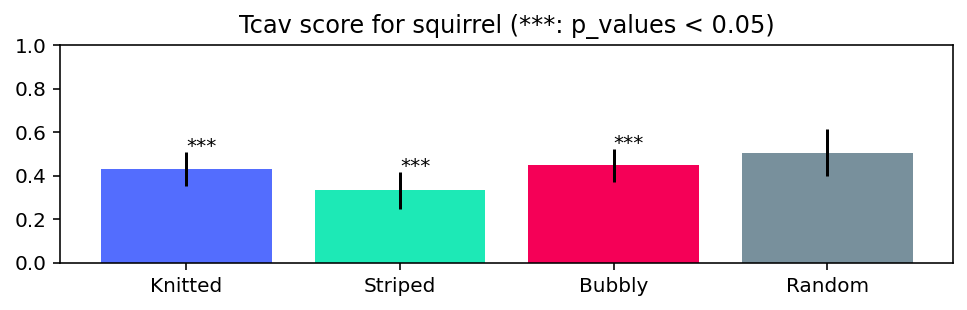

In [13]:
from scipy.stats import ttest_ind
plt.rcParams["figure.figsize"] = [8, 2]

for class_name in tcav_scores.keys():

  concept_score = []
  
  for concept_id, concept_name in enumerate(tcav_scores[class_name].keys()):
      scores = tcav_scores[class_name][concept_name]
      mean = np.mean(scores)
      std = np.std(scores)

      concept_score.append((concept_name, mean, std))

  # we will plot mean and std of the TCAV scores
  means = [mean for concept_name, mean, std in concept_score]
  stds  = [std for concept_name, mean, std in concept_score]
  # the p-values will attests to the significance of a cav in relation to random cavs
  p_values = [ttest_ind(tcav_scores[class_name][concept_name], 
                        tcav_scores[class_name]['random'], equal_var = True)[1] 
              for concept_name in tcav_scores[class_name].keys()]
  
  # plot the bar and their stds
  plt.bar(range(len(concept_score)),
          height=means, yerr=stds, 
          color=["#536DFE", "#1DE9B6", "#F50057", "#78909C"])
  # add '***' if the t-test is passed else 'x'
  for index, data in enumerate(p_values[:-1]):
    plt.text(x=index , y=means[index] + stds[index], s=f"{'***' if data < 0.05 else 'x'}")

  plt.xticks(range(len(concept_score)), [concept_name.capitalize() for concept_name, mean, std in concept_score])
  plt.ylim([0.0, 1.0])
  plt.title(f"Tcav score for {class_name} (***: p_values < 0.05)")
  plt.show()


The Striped concept helps significantly with the zebra class! 
The other concepts either don't help or are not significant (except for the Knited concept which seems to improve very slightly for the squirrels).

# 🎉 Congratulations
**you now know how to use the Concept module of Xplique !**